In [1]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr

import dask
import ncar_jobqueue

from src import data_catalog
from src import tseries_mod
from src import utils_data_catalog
from src import esmlab_wrap
from src.utils import print_timestamp, repl_coord, smooth, regression_slope

In [2]:
data_catalog.set_catalog('cesm_coupled')

active catalog: experiments


In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", module=".*dashboard")
    cluster = ncar_jobqueue.NCARCluster()
cluster.scale(32)
client = dask.distributed.Client(cluster)
print(f"dashboard_link={cluster.dashboard_link}")

dashboard_link=https://jupyterhub.ucar.edu/dav/user/klindsay/proxy/8787/status


In [4]:
varnames_x = {'atm': ['TS']}

ds_dict_x = {}
for component in varnames_x:
    ds_dict_x[component] = {}

for experiment in ['piControl']:
    for component in varnames_x:
        ds_dict_x[component][experiment] = tseries_mod.tseries_get_vars(varnames_x[component], component, experiment)

for experiment in ['piControl-cmip5']:
    for component in varnames_x:
        if component == 'atm':
            ds_dict_x[component][experiment] = tseries_mod.tseries_get_vars(varnames_x[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict_x[component][experiment] = tseries_mod.tseries_get_vars(varnames_x[component], component, experiment)

In [5]:
# varnames_y = {'atm': ['TS', 'SFCO2_LND'],
#               'lnd': ['GPP', 'NPP', 'AR', 'TOTVEGC', 'HR', 'TOTSOMC', 'ER'],
#              }
varnames_y = {'atm': ['SFCO2_LND'],
              'lnd': ['GPP', 'HR'],
             }

ds_dict_y = {}
for component in varnames_y:
    ds_dict_y[component] = {}

for experiment in ['piControl']:
    for component in varnames_y:
        ds_dict_y[component][experiment] = utils_data_catalog.gen_ds_vars(varnames_y[component], component, experiment)

for experiment in ['piControl-cmip5']:
    for component in varnames_y:
        if component == 'atm':
            ds_dict_y[component][experiment] = utils_data_catalog.gen_ds_vars(varnames_y[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict_y[component][experiment] = utils_data_catalog.gen_ds_vars(varnames_y[component], component, experiment)

legend_dict = {'piControl': 'piControl, CESM2',
               'piControl-cmip5': 'piControl, CESM1(BGC)',
              }

2020-01-30 17:05:33.730246(gen_ds_var):entering gen_ds_var, varname=SFCO2_LND, experiment=piControl
2020-01-30 17:05:39.602850(gen_ds_var):entering gen_ds_var, varname=GPP, experiment=piControl
2020-01-30 17:05:42.255038(gen_ds_var):entering gen_ds_var, varname=HR, experiment=piControl
2020-01-30 17:06:03.118648(gen_ds_var):entering gen_ds_var, varname=SFCO2_LND, experiment=piControl-cmip5
2020-01-30 17:06:31.558253(gen_ds_var):entering gen_ds_var, varname=GPP, experiment=piControl-cmip5
2020-01-30 17:06:50.871916(gen_ds_var):entering gen_ds_var, varname=HR, experiment=piControl-cmip5


In [10]:
def corr_anal(varname_pair, expr_list, component_pair=('atm', 'atm'), region_x='nino34', **kwargs):
    lag_values = range(-6, 6+1, 2)
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    for experiment in expr_list:
        # construct da_x
        tb_name = ds_dict_x[component_x][experiment]['time'].attrs['bounds']
        ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict_x[component_x][experiment][[tb_name, varname_x]]).chunk({'time': -1})
        iseldict = {}
        if 'lev' in ds_x[varname_x].dims:
            iseldict['lev'] = -1
        da_x = ds_x[varname_x].sel(region=region_x).isel(iseldict)

        # construct da_y
        # replace time with ds_x's time, so that vars are aligned in corr computation
        tb_name = ds_dict_y[component_y][experiment]['time'].attrs['bounds']
        ds_tmp = repl_coord('time', ds_x, ds_dict_y[component_y][experiment][[tb_name, varname_y]])
        ds_tmp = ds_tmp.sel({'lat': slice(-60.0, 80.0)})
        ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp).chunk({'time': -1, 'lat': 32, 'lon': 32})
        ds_y = repl_coord('time', ds_x, ds_y)
        iseldict = {}
        if 'lev' in ds_y[varname_y].dims:
            iseldict['lev'] = -1
        da_y = ds_y[varname_y].isel(iseldict)

        # filter da_x and da_y
        for da in [da_x, da_y]:
            print_timestamp(f"calling smooth for {da.name}")
            da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
            print_timestamp(f"smooth returned")
            da -= da_sm

        for lag_y in lag_values:
            print(f'varname_x={varname_x}, varname_y={varname_y}, lag_y={lag_y}, experiment={experiment}')

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_shift = da_y.shift({'time': -lag_y})
            if lag_y < 0:
                time_slice = slice(smooth_edge_len-lag_y, -smooth_edge_len)
            else:
                time_slice = slice(smooth_edge_len, -smooth_edge_len-lag_y)

            time_slice = slice("0200-01-01", "0300-01-01")

            da_slope = regression_slope(
                da_x.sel(time=time_slice),
                da_y_shift.sel(time=time_slice)
            )

            fig, ax = plt.subplots()
            da_slope.plot(ax=ax, **kwargs)
            ax.grid(True)
            plt.show()


/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 17:16:18.708698(corr_anal):calling smooth for TS
2020-01-30 17:16:18.762609(corr_anal):smooth returned
2020-01-30 17:16:18.784648(corr_anal):calling smooth for SFCO2_LND
2020-01-30 17:16:18.851250(corr_anal):smooth returned
varname_x=TS, varname_y=SFCO2_LND, lag_y=-6, experiment=piControl


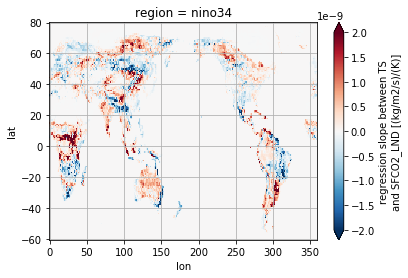

varname_x=TS, varname_y=SFCO2_LND, lag_y=-4, experiment=piControl


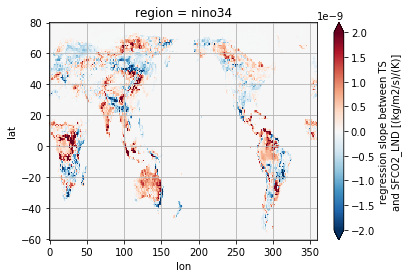

varname_x=TS, varname_y=SFCO2_LND, lag_y=-2, experiment=piControl


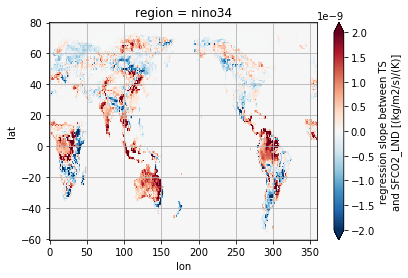

varname_x=TS, varname_y=SFCO2_LND, lag_y=0, experiment=piControl


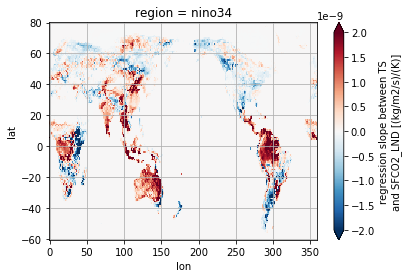

varname_x=TS, varname_y=SFCO2_LND, lag_y=2, experiment=piControl


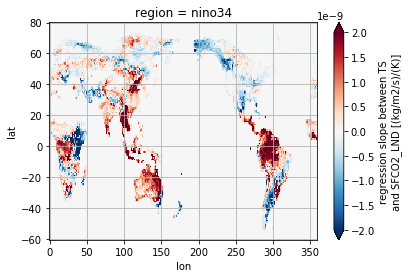

varname_x=TS, varname_y=SFCO2_LND, lag_y=4, experiment=piControl


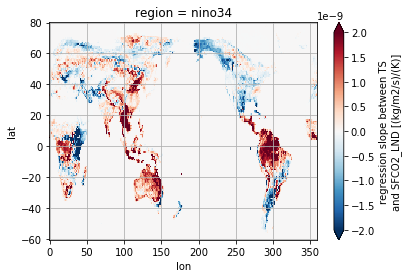

varname_x=TS, varname_y=SFCO2_LND, lag_y=6, experiment=piControl


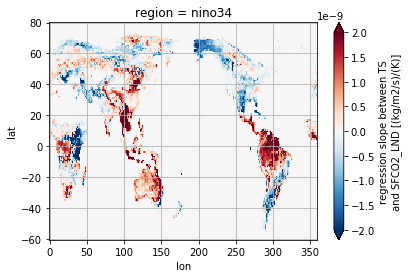

/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 17:21:37.123234(corr_anal):calling smooth for TS
2020-01-30 17:21:37.176611(corr_anal):smooth returned
2020-01-30 17:21:37.194595(corr_anal):calling smooth for SFCO2_LND
2020-01-30 17:21:37.263247(corr_anal):smooth returned
varname_x=TS, varname_y=SFCO2_LND, lag_y=-6, experiment=piControl-cmip5


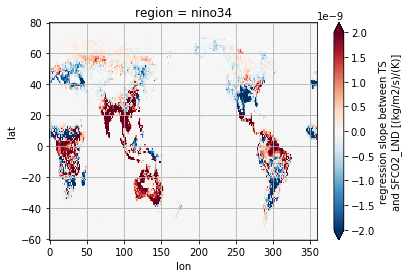

varname_x=TS, varname_y=SFCO2_LND, lag_y=-4, experiment=piControl-cmip5


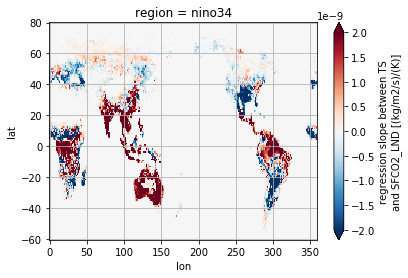

varname_x=TS, varname_y=SFCO2_LND, lag_y=-2, experiment=piControl-cmip5


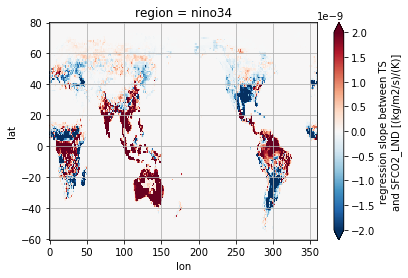

varname_x=TS, varname_y=SFCO2_LND, lag_y=0, experiment=piControl-cmip5


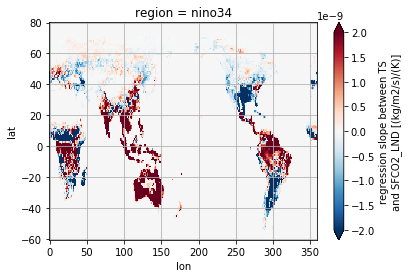

varname_x=TS, varname_y=SFCO2_LND, lag_y=2, experiment=piControl-cmip5


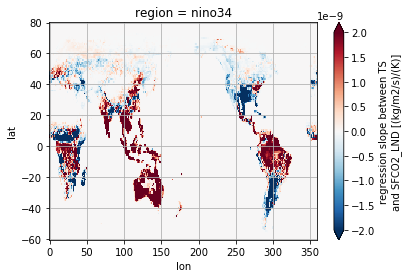

varname_x=TS, varname_y=SFCO2_LND, lag_y=4, experiment=piControl-cmip5


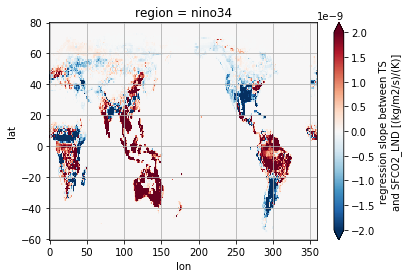

varname_x=TS, varname_y=SFCO2_LND, lag_y=6, experiment=piControl-cmip5


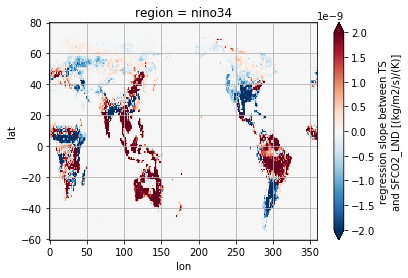

In [11]:
corr_anal(('TS', 'SFCO2_LND'), ['piControl', 'piControl-cmip5'], center=0.0, vmax=2.0e-9)

/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 17:41:59.718560(corr_anal):calling smooth for TS
2020-01-30 17:41:59.778558(corr_anal):smooth returned
2020-01-30 17:41:59.799133(corr_anal):calling smooth for GPP
2020-01-30 17:41:59.876387(corr_anal):smooth returned
varname_x=TS, varname_y=GPP, lag_y=-6, experiment=piControl


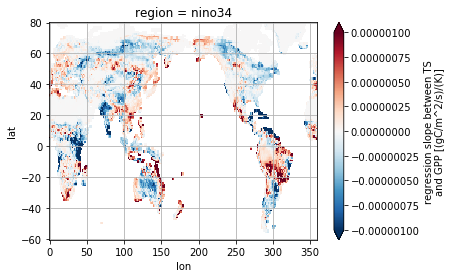

varname_x=TS, varname_y=GPP, lag_y=-4, experiment=piControl


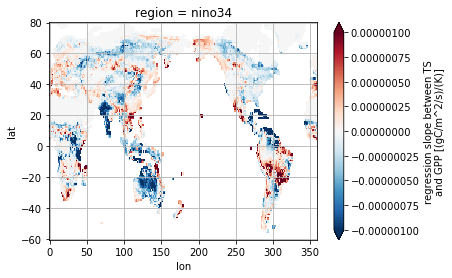

varname_x=TS, varname_y=GPP, lag_y=-2, experiment=piControl


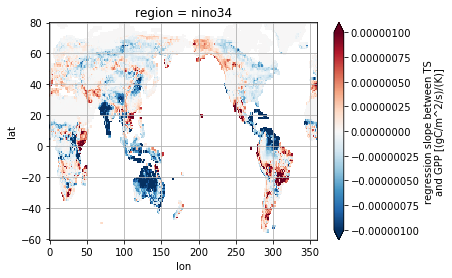

varname_x=TS, varname_y=GPP, lag_y=0, experiment=piControl


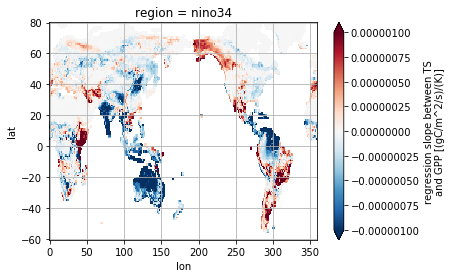

varname_x=TS, varname_y=GPP, lag_y=2, experiment=piControl


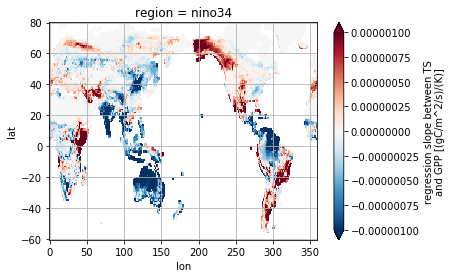

varname_x=TS, varname_y=GPP, lag_y=4, experiment=piControl


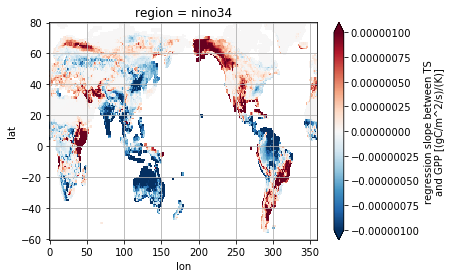

varname_x=TS, varname_y=GPP, lag_y=6, experiment=piControl


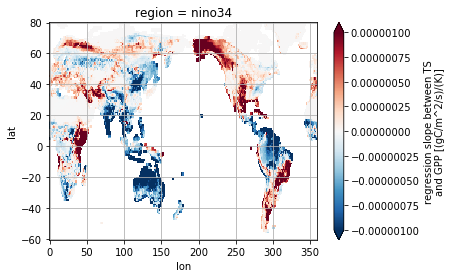

/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 17:47:43.698023(corr_anal):calling smooth for TS
2020-01-30 17:47:43.751746(corr_anal):smooth returned
2020-01-30 17:47:43.776943(corr_anal):calling smooth for GPP
2020-01-30 17:47:43.846140(corr_anal):smooth returned
varname_x=TS, varname_y=GPP, lag_y=-6, experiment=piControl-cmip5


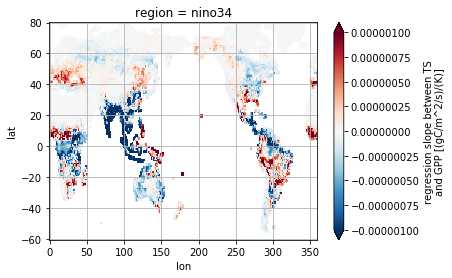

varname_x=TS, varname_y=GPP, lag_y=-4, experiment=piControl-cmip5


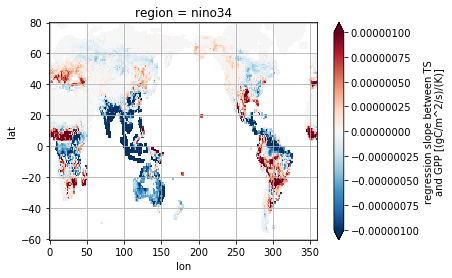

varname_x=TS, varname_y=GPP, lag_y=-2, experiment=piControl-cmip5


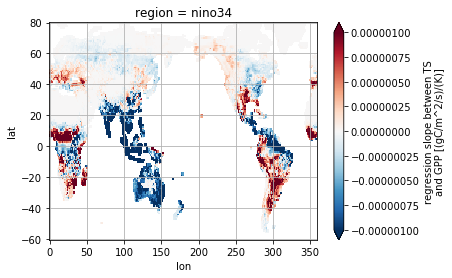

varname_x=TS, varname_y=GPP, lag_y=0, experiment=piControl-cmip5


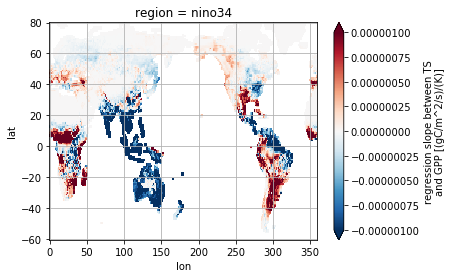

varname_x=TS, varname_y=GPP, lag_y=2, experiment=piControl-cmip5


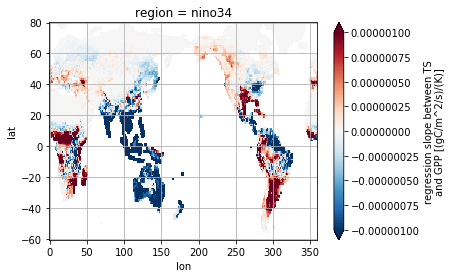

varname_x=TS, varname_y=GPP, lag_y=4, experiment=piControl-cmip5


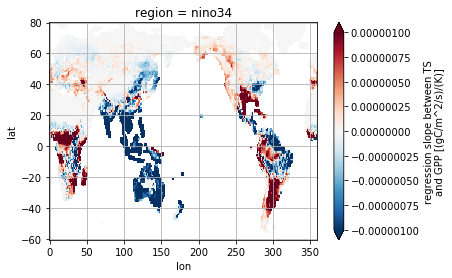

varname_x=TS, varname_y=GPP, lag_y=6, experiment=piControl-cmip5


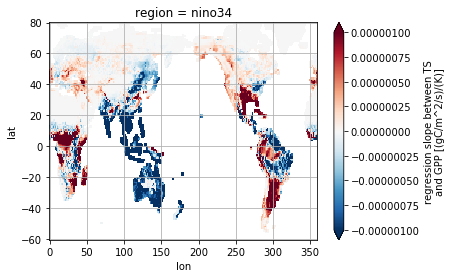

In [12]:
corr_anal(('TS', 'GPP'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), center=0.0, vmax=1.0e-6)

/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 18:01:24.131498(corr_anal):calling smooth for TS
2020-01-30 18:01:24.182006(corr_anal):smooth returned
2020-01-30 18:01:24.201297(corr_anal):calling smooth for HR
2020-01-30 18:01:24.286564(corr_anal):smooth returned
varname_x=TS, varname_y=HR, lag_y=-6, experiment=piControl


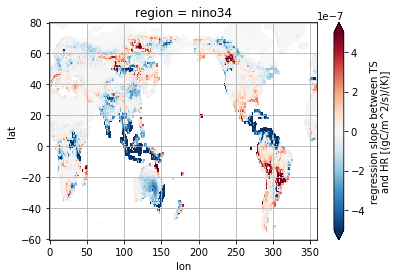

varname_x=TS, varname_y=HR, lag_y=-4, experiment=piControl


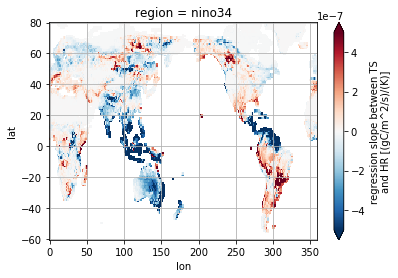

varname_x=TS, varname_y=HR, lag_y=-2, experiment=piControl


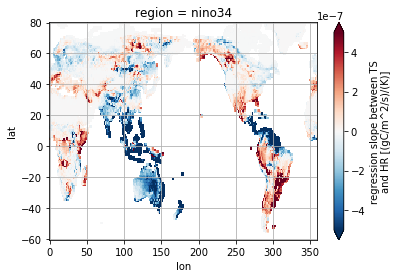

varname_x=TS, varname_y=HR, lag_y=0, experiment=piControl


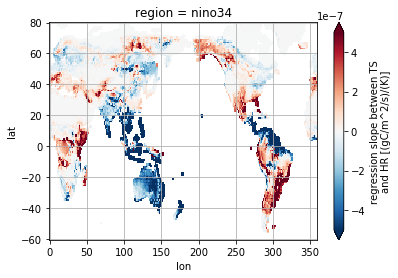

varname_x=TS, varname_y=HR, lag_y=2, experiment=piControl


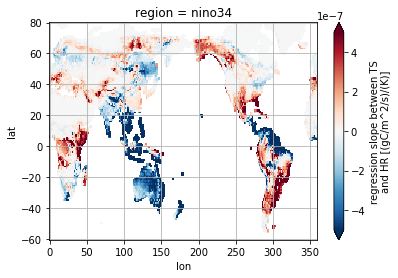

varname_x=TS, varname_y=HR, lag_y=4, experiment=piControl


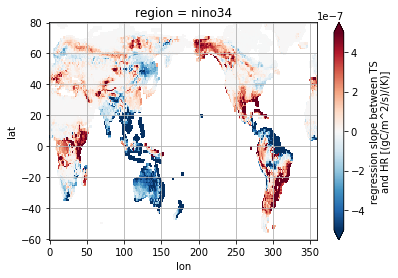

varname_x=TS, varname_y=HR, lag_y=6, experiment=piControl


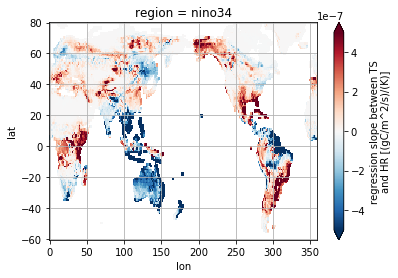

/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


2020-01-30 18:06:44.959229(corr_anal):calling smooth for TS
2020-01-30 18:06:45.017727(corr_anal):smooth returned
2020-01-30 18:06:45.041504(corr_anal):calling smooth for HR
2020-01-30 18:06:45.123199(corr_anal):smooth returned
varname_x=TS, varname_y=HR, lag_y=-6, experiment=piControl-cmip5


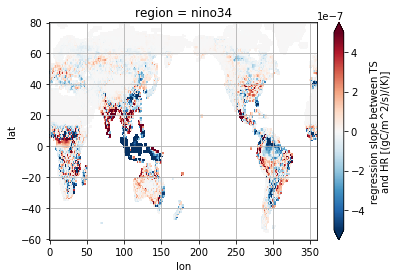

varname_x=TS, varname_y=HR, lag_y=-4, experiment=piControl-cmip5


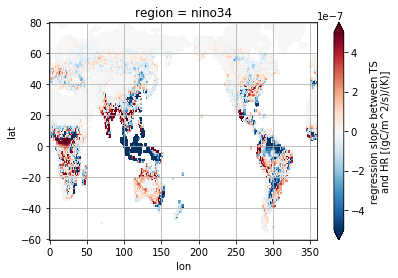

varname_x=TS, varname_y=HR, lag_y=-2, experiment=piControl-cmip5


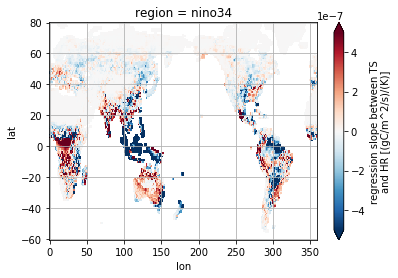

varname_x=TS, varname_y=HR, lag_y=0, experiment=piControl-cmip5


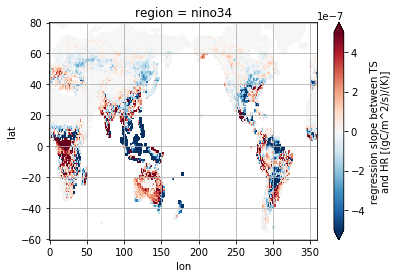

varname_x=TS, varname_y=HR, lag_y=2, experiment=piControl-cmip5


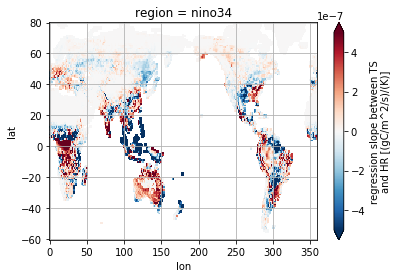

varname_x=TS, varname_y=HR, lag_y=4, experiment=piControl-cmip5


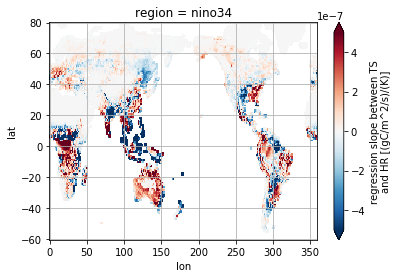

varname_x=TS, varname_y=HR, lag_y=6, experiment=piControl-cmip5


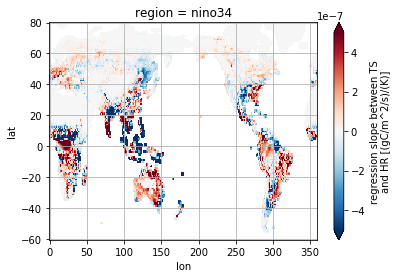

In [13]:
corr_anal(('TS', 'HR'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), center=0.0, vmax=5.0e-7)

In [14]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/distributed/client.py", line 1311, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/glade/work/klindsay/miniconda3/envs/CESM2_coup_carb_cycle_JAMES/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/glade/work/klindsay/mi